# Comparison between GoiStrat and naïve solution

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Imports

In [2]:
import sys
import pandas as pd
import seaborn as sns
import numpy as np

from IPython.display import display
from typing import Iterable, Dict
from itertools import product
import matplotlib.pyplot as plt
from pathlib import Path

Setup

In [3]:
src_path: str = "/home/uziel/Development/goi-strat/src"
sys.path.insert(0, src_path)

In [4]:
from data.utils import calculate_power

In [5]:
ROOT: Path = Path("/mnt/d/phd_data/")
MSIGDB_CATS: Iterable[str] = ("H", *[f"C{i}" for i in range(1, 9)])
DATASETS_MARKERS: Dict[str, str] = {
    "TCGA-BRCA": "BRCA1",  # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8998777/
    "TCGA-LUAD": "NKX2-1",  # https://www.nature.com/articles/nature09881
    "TCGA-THCA": "HMGA2",  # https://pubmed.ncbi.nlm.nih.gov/17943974/
    "TCGA-UCEC": "PIK3CA",  # https://pubmed.ncbi.nlm.nih.gov/28860563/, https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3060282/
    "TCGA-LUSC": "SOX2",  # https://www.cell.com/cancer-cell/fulltext/S1535-6108(16)30436-6
    "TCGA-KIRC": "CA9",  # https://www.sciencedirect.com/science/article/abs/pii/S0959804910006982
    "TCGA-HNSC": "TP63",  # https://aacrjournals.org/mcr/article/17/6/1279/270274/Loss-of-TP63-Promotes-the-Metastasis-of-Head-and
    "TCGA-LGG": "IDH1",  # https://www.neurology.org/doi/abs/10.1212/wnl.0b013e3181f96282
    "PCTA_WCDT": "FOLH1",  # https://www.nature.com/articles/nrurol.2016.26
}
PERCENTILES: Iterable[int] = (10, 15, 20, 25, 30)
RENAME_DICT: Dict = {
    "GOI_level": "GoiStrat (*/50/*)",
    "GOI_level_10": "10 / 80 / 10",
    "GOI_level_15": "15 / 70 / 15",
    "GOI_level_20": "20 / 60 / 20",
    "GOI_level_25": "25 / 50 / 25",
    "GOI_level_30": "30 / 40 / 30",
}
SAMPLE_TYPE: str = "prim"
PALETTE_STR: str = "coolwarm"  # coolwarm or flare
EFFECT_SIZE: float = 0.5
ALPHA: float = 0.05

sns.set_theme(style="whitegrid", palette=PALETTE_STR)
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Ubuntu Mono"
plt.rcParams["font.monospace"] = "Ubuntu Mono"

Global variables

In [6]:
MULTI_DATASET_PATH: Path = ROOT.joinpath("MULTI_DATASET")
MULTI_DATASET_PATH.mkdir(parents=True, exist_ok=True)

## 1. Explore dataset characteristics

### 1.1. Annotation data from all splits

In [7]:
group_counts = dict()
for dataset, marker in DATASETS_MARKERS.items():
    data_root = ROOT.joinpath(f"{dataset}_{marker}")
    annot_df = pd.read_csv(
        data_root.joinpath("data").joinpath(f"samples_annotation_{marker}_gsva.csv"),
        index_col=0,
    )
    contrast_factor = f"{marker}_level"
    group_counts[(dataset + f" ({marker})", "GOI_level")] = (
        annot_df[contrast_factor].value_counts().to_dict()
    )
    group_counts[(dataset + f" ({marker})", "GOI_level")].update(
        {"total": len(annot_df)}
    )

    for percentile in PERCENTILES:
        annot_df = pd.read_csv(
            data_root.joinpath("data").joinpath(
                f"samples_annotation_{marker}_perc.csv"
            ),
            index_col=0,
        )
        contrast_factor = f"{marker}_level_{percentile}"
        group_counts[(dataset + f" ({marker})", f"GOI_level_{percentile}")] = (
            annot_df[contrast_factor].value_counts().to_dict()
        )
        group_counts[(dataset + f" ({marker})", f"GOI_level_{percentile}")].update(
            {"total": len(annot_df)}
        )

group_counts_df = pd.DataFrame(group_counts).T
group_counts_df.to_csv(MULTI_DATASET_PATH.joinpath("group_counts_all_df.csv"))
display(group_counts_df)

mid  low  high  total
TCGA-BRCA (BRCA1)  GOI_level     553  420   133   1106
                   GOI_level_10  884  111   111   1106
                   GOI_level_15  774  166   166   1106
                   GOI_level_20  664  221   221   1106
                   GOI_level_25  552  277   277   1106
                   GOI_level_30  442  332   332   1106
TCGA-LUAD (NKX2-1) GOI_level     264  212    52    528
                   GOI_level_10  422   53    53    528
                   GOI_level_15  368   80    80    528
                   GOI_level_20  316  106   106    528
                   GOI_level_25  264  132   132    528
                   GOI_level_30  210  159   159    528
TCGA-THCA (HMGA2)  GOI_level     252   51   202    505
                   GOI_level_10  403   51    51    505
                   GOI_level_15  353   76    76    505
                   GOI_level_20  303  101   101    505
                   GOI_level_25  253  126   126    505
                   GOI_level_30  201  152   152    505
TCGA-UCEC (PIK3CA) GOI_level     274   54   221    549
                   GOI_level_10  439   55    55    549
                   GOI_level_15  383   83    83    549
                   GOI_level_20  329  110   110    549
                   GOI_level_25  275  137   137    549
                   GOI_level_30  219  165   165    549
TCGA-LUSC (SOX2)   GOI_level     250  197    54    501
                   GOI_level_10  401   50    50    501
                   GOI_level_15  351   75    75    501
                   GOI_level_20  301  100   100    501
                   GOI_level_25  251  125   125    501
                   GOI_level_30  201  150   150    501
TCGA-KIRC (CA9)    GOI_level     268  216    53    537
                   GOI_level_10  429   54    54    537
                   GOI_level_15  375   81    81    537
                   GOI_level_20  321  108   108    537
                   GOI_level_25  269  134   134    537
                   GOI_level_30  215  161   161    537
TCGA-HNSC (TP63)   GOI_level     260  199    61    520
                   GOI_level_10  416   52    52    520
                   GOI_level_15  364   78    78    520
                   GOI_level_20  312  104   104    520
                   GOI_level_25  260  130   130    520
                   GOI_level_30  208  156   156    520
TCGA-LGG (IDH1)    GOI_level     258   51   207    516
                   GOI_level_10  412   52    52    516
                   GOI_level_15  360   78    78    516
                   GOI_level_20  310  103   103    516
                   GOI_level_25  258  129   129    516
                   GOI_level_30  206  155   155    516
PCTA_WCDT (FOLH1)  GOI_level     331  241    90    662
                   GOI_level_10  528   67    67    662
                   GOI_level_15  462  100   100    662
                   GOI_level_20  396  133   133    662
                   GOI_level_25  330  166   166    662
                   GOI_level_30  264  199   199    662

In [8]:
# Function to apply calculate_power to each row
def calculate_row_power(row: pd.Series) -> float:
    """
    Calculate the test power for a given row using the low and high values.

    Parameters:
    - row: A pandas Series representing a row of the DataFrame.

    Returns:
    - float: The calculated power for the row.
    """
    return calculate_power(
        effect_size=EFFECT_SIZE, alpha=ALPHA, n1=row["low"], n2=row["high"]
    )


# Apply the function to each row and create a new column 'power'
group_counts_df["power"] = group_counts_df.apply(calculate_row_power, axis=1)

group_counts_df.to_csv(MULTI_DATASET_PATH.joinpath("group_counts_df_with_power.csv"))
# Display the updated DataFrame
display(group_counts_df)

mid  low  high  total     power
TCGA-BRCA (BRCA1)  GOI_level     553  420   133   1106  0.998880
                   GOI_level_10  884  111   111   1106  0.959824
                   GOI_level_15  774  166   166   1106  0.995088
                   GOI_level_20  664  221   221   1106  0.999489
                   GOI_level_25  552  277   277   1106  1.000000
                   GOI_level_30  442  332   332   1106  1.000000
TCGA-LUAD (NKX2-1) GOI_level     264  212    52    528  0.896017
                   GOI_level_10  422   53    53    528  0.722445
                   GOI_level_15  368   80    80    528  0.881602
                   GOI_level_20  316  106   106    528  0.951883
                   GOI_level_25  264  132   132    528  0.981561
                   GOI_level_30  210  159   159    528  0.993515
TCGA-THCA (HMGA2)  GOI_level     252   51   202    505  0.888462
                   GOI_level_10  403   51    51    505  0.705613
                   GOI_level_15  353   76    76    505  0.864867
                   GOI_level_20  303  101   101    505  0.942498
                   GOI_level_25  253  126   126    505  0.976890
                   GOI_level_30  201  152   152    505  0.991461
TCGA-UCEC (PIK3CA) GOI_level     274   54   221    549  0.906953
                   GOI_level_10  439   55    55    549  0.738487
                   GOI_level_15  383   83    83    549  0.892908
                   GOI_level_20  329  110   110    549  0.958341
                   GOI_level_25  275  137   137    549  0.984753
                   GOI_level_30  219  165   165    549  0.994888
TCGA-LUSC (SOX2)   GOI_level     250  197    54    501  0.900175
                   GOI_level_10  401   50    50    501  0.696893
                   GOI_level_15  351   75    75    501  0.860368
                   GOI_level_20  301  100   100    501  0.940427
                   GOI_level_25  251  125   125    501  0.976009
                   GOI_level_30  201  150   150    501  0.990768
TCGA-KIRC (CA9)    GOI_level     268  216    53    537  0.901491
                   GOI_level_10  429   54    54    537  0.730564
                   GOI_level_15  375   81    81    537  0.885485
                   GOI_level_20  321  108   108    537  0.955221
                   GOI_level_25  269  134   134    537  0.982908
                   GOI_level_30  215  161   161    537  0.994008
TCGA-HNSC (TP63)   GOI_level     260  199    61    520  0.925594
                   GOI_level_10  416   52    52    520  0.714129
                   GOI_level_15  364   78    78    520  0.873482
                   GOI_level_20  312  104   104    520  0.948315
                   GOI_level_25  260  130   130    520  0.980114
                   GOI_level_30  208  156   156    520  0.992701
TCGA-LGG (IDH1)    GOI_level     258   51   207    516  0.889976
                   GOI_level_10  412   52    52    516  0.714129
                   GOI_level_15  360   78    78    516  0.873482
                   GOI_level_20  310  103   103    516  0.946439
                   GOI_level_25  258  129   129    516  0.979351
                   GOI_level_30  206  155   155    516  0.992408
PCTA_WCDT (FOLH1)  GOI_level     331  241    90    662  0.981038
                   GOI_level_10  528   67    67    662  0.819348
                   GOI_level_15  462  100   100    662  0.940427
                   GOI_level_20  396  133   133    662  0.982247
                   GOI_level_25  330  166   166    662  0.995088
                   GOI_level_30  264  199   199    662  0.998717

In [9]:
power_map = group_counts_df["power"].to_dict()
print(power_map)

{('TCGA-BRCA (BRCA1)', 'GOI_level'): 0.9988803442132566, ('TCGA-BRCA (BRCA1)', 'GOI_level_10'): 0.9598236158634741, ('TCGA-BRCA (BRCA1)', 'GOI_level_15'): 0.9950879206127476, ('TCGA-BRCA (BRCA1)', 'GOI_level_20'): 0.9994891339216804, ('TCGA-BRCA (BRCA1)', 'GOI_level_25'): 1.0, ('TCGA-BRCA (BRCA1)', 'GOI_level_30'): 1.0, ('TCGA-LUAD (NKX2-1)', 'GOI_level'): 0.8960165794812585, ('TCGA-LUAD (NKX2-1)', 'GOI_level_10'): 0.7224452892573963, ('TCGA-LUAD (NKX2-1)', 'GOI_level_15'): 0.8816024847721196, ('TCGA-LUAD (NKX2-1)', 'GOI_level_20'): 0.9518832387085298, ('TCGA-LUAD (NKX2-1)', 'GOI_level_25'): 0.9815614364531526, ('TCGA-LUAD (NKX2-1)', 'GOI_level_30'): 0.9935148960423404, ('TCGA-THCA (HMGA2)', 'GOI_level'): 0.8884624463286505, ('TCGA-THCA (HMGA2)', 'GOI_level_10'): 0.7056125740521042, ('TCGA-THCA (HMGA2)', 'GOI_level_15'): 0.8648673142097211, ('TCGA-THCA (HMGA2)', 'GOI_level_20'): 0.9424975311351828, ('TCGA-THCA (HMGA2)', 'GOI_level_25'): 0.9768896517490835, ('TCGA-THCA (HMGA2)', 'GOI_le

## 2. Gather and compare differential expression results

Differential expression results between low and high groups for each dataset and splitting strategy.

In [10]:
all_degs = dict()
all_degs_scores = dict()
for dataset, marker in DATASETS_MARKERS.items():
    contrast_factors = [
        f"{marker}_level_{percentile}" for percentile in PERCENTILES
    ] + [f"{marker}_level"]
    data_root = ROOT.joinpath(f"{dataset}_{marker}")

    for contrast_factor in contrast_factors:
        deseq_results = pd.read_csv(
            data_root.joinpath("deseq2").joinpath(
                f"sample_type_{SAMPLE_TYPE}_{contrast_factor}_"
                f"{SAMPLE_TYPE}_high+{SAMPLE_TYPE}_low_"
                f"_{SAMPLE_TYPE}_high_vs_{SAMPLE_TYPE}_low_"
                "padj_0_05_all_1_0_deseq_results_unique.csv"
            ),
            index_col=0,
        )
        contrast_factor_str = contrast_factor.replace(marker, "GOI")
        all_degs[(dataset + f" ({marker})", contrast_factor_str)] = deseq_results[
            "log2FoldChange"
        ]
        all_degs_scores[(dataset + f" ({marker})", contrast_factor_str)] = (
            deseq_results["log2FoldChange"].pipe(
                lambda x: np.sqrt(np.mean(np.power(x, 2)))
            )
        )

all_degs_df = pd.DataFrame(all_degs)

In [11]:
all_degs_scores_df = pd.Series(all_degs_scores).unstack(level=0).transpose()
all_degs_scores_df.to_csv(MULTI_DATASET_PATH.joinpath("all_degs_scores_df.csv"))
display(all_degs_scores_df)

,GOI_level,GOI_level_10,GOI_level_15,GOI_level_20,GOI_level_25,GOI_level_30
PCTA_WCDT (FOLH1),1.523208,1.724276,1.597775,1.571454,1.508589,1.479444
TCGA-BRCA (BRCA1),1.531838,1.633386,1.624730,1.780670,1.740930,1.774753
TCGA-HNSC (TP63),1.483313,1.598803,1.541048,1.481256,1.474818,1.442893
TCGA-KIRC (CA9),1.896113,2.267806,2.327118,2.354664,2.323584,2.206625
TCGA-LGG (IDH1),1.781794,1.878264,1.786128,1.681172,1.612114,1.537598
TCGA-LUAD (NKX2-1),1.947659,2.276284,2.178660,2.110323,2.083919,2.007937
TCGA-LUSC (SOX2),1.795002,1.999208,1.926709,1.873019,1.822779,1.799866
TCGA-THCA (HMGA2),2.315340,2.330369,2.117451,1.950802,1.905669,1.838849
TCGA-UCEC (PIK3CA),1.616146,1.823093,1.735578,1.711255,1.680427,1.631354


In [12]:
def apply_function(df, func):
    for row_idx, row in df.iterrows():
        for col_idx, value in row.items():
            df.at[row_idx, col_idx] = value * func[(row_idx, col_idx)]
    return df


all_degs_scores_df_weighted = apply_function(all_degs_scores_df, power_map)
all_degs_scores_df_weighted.to_csv(
    MULTI_DATASET_PATH.joinpath("all_degs_scores_df_weighted.csv")
)
display(all_degs_scores_df_weighted)

,GOI_level,GOI_level_10,GOI_level_15,GOI_level_20,GOI_level_25,GOI_level_30
PCTA_WCDT (FOLH1),1.494325,1.412781,1.502591,1.543556,1.501179,1.477546
TCGA-BRCA (BRCA1),1.530123,1.567762,1.616749,1.779760,1.740930,1.774753
TCGA-HNSC (TP63),1.372945,1.141752,1.346077,1.404697,1.445491,1.432361
TCGA-KIRC (CA9),1.709328,1.656777,2.060628,2.249224,2.283869,2.193403
TCGA-LGG (IDH1),1.585753,1.341323,1.560151,1.591127,1.578825,1.525925
TCGA-LUAD (NKX2-1),1.745135,1.644491,1.920712,2.008781,2.045494,1.994915
TCGA-LUSC (SOX2),1.615815,1.393235,1.657678,1.761438,1.779049,1.783249
TCGA-THCA (HMGA2),2.057093,1.644337,1.831314,1.838626,1.861628,1.823148
TCGA-UCEC (PIK3CA),1.465768,1.346329,1.549712,1.639966,1.654806,1.623015


In [13]:
all_degs_scores_df_weighted_ranked = all_degs_scores_df_weighted.rank(
    axis=1, method="max", ascending=False
).astype(int)
all_degs_scores_df_weighted_ranked.to_csv(
    MULTI_DATASET_PATH.joinpath("all_degs_scores_df_weighted_ranked.csv")
)
display(all_degs_scores_df_weighted_ranked)

,GOI_level,GOI_level_10,GOI_level_15,GOI_level_20,GOI_level_25,GOI_level_30
PCTA_WCDT (FOLH1),4,6,2,1,3,5
TCGA-BRCA (BRCA1),6,5,4,1,3,2
TCGA-HNSC (TP63),4,6,5,3,1,2
TCGA-KIRC (CA9),5,6,4,2,1,3
TCGA-LGG (IDH1),2,6,4,1,3,5
TCGA-LUAD (NKX2-1),5,6,4,2,1,3
TCGA-LUSC (SOX2),5,6,4,3,2,1
TCGA-THCA (HMGA2),1,6,4,3,2,5
TCGA-UCEC (PIK3CA),5,6,4,2,1,3


In [14]:
all_degs_scores_df_weighted_ranked_summary = (
    all_degs_scores_df_weighted_ranked.median().sort_values(ascending=True)
)
all_degs_scores_df_weighted_ranked_summary.to_csv(
    MULTI_DATASET_PATH.joinpath("all_degs_scores_df_weighted_ranked_summary.csv")
)
display(all_degs_scores_df_weighted_ranked_summary)

GOI_level_20    2.0
GOI_level_25    2.0
GOI_level_30    3.0
GOI_level_15    4.0
GOI_level       5.0
GOI_level_10    6.0
dtype: float64

### 2.1. Visualise results

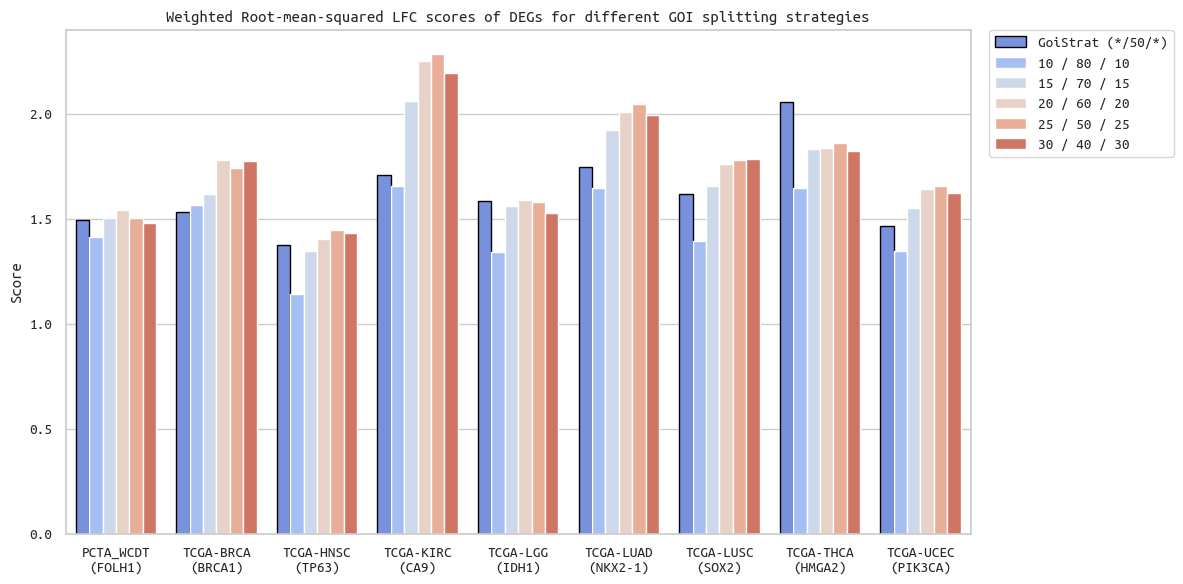

In [15]:
# Melt the DataFrame to long format for seaborn
all_degs_scores_df_weighted_melted = all_degs_scores_df_weighted.reset_index().melt(
    id_vars="index", var_name="Column", value_name="Score"
)

all_degs_scores_df_weighted_melted["Column"] = all_degs_scores_df_weighted_melted[
    "Column"
].map(RENAME_DICT)
all_degs_scores_df_weighted_melted["index"] = all_degs_scores_df_weighted_melted[
    "index"
].str.replace(" (", "\n(")

# Create the barplot
plt.figure(figsize=(12, 6))
barplot = sns.barplot(
    data=all_degs_scores_df_weighted_melted,
    x="index",
    y="Score",
    hue="Column",
    palette=PALETTE_STR,
)

# Customize the plot
plt.xlabel("")
plt.ylabel("Score")
plt.title(
    "Weighted Root-mean-squared LFC scores of DEGs for different GOI splitting strategies"
)

# Add a black border to the bar corresponding to "GOI_level"
for patch, level in zip(barplot.patches, all_degs_scores_df_weighted_melted["Column"]):
    if level == "GoiStrat (*/50/*)":
        patch.set_edgecolor("black")
        patch.set_linewidth(1)

# Move the legend outside of the figure
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.0)

# Show the plot
plt.tight_layout()

plt.savefig(
    MULTI_DATASET_PATH.joinpath("all_degs_scores_df_weighted_barplot.pdf"),
    bbox_inches="tight",
)
plt.savefig(
    MULTI_DATASET_PATH.joinpath("all_degs_scores_df_weighted_barplot.svg"),
    bbox_inches="tight",
)

plt.show()

## 3. Gather and compare differential enrichment results

Differential enrichment results between low and high groups for each dataset and splitting strategy.

In [16]:
all_degss = dict()
all_degss_scores = dict()
for dataset, marker in DATASETS_MARKERS.items():
    contrast_factors = [
        f"{marker}_level_{percentile}" for percentile in PERCENTILES
    ] + [f"{marker}_level"]
    data_root = ROOT.joinpath(f"{dataset}_{marker}")
    msigdb_cats_meta_dfs = {
        msigdb_cat: pd.read_csv(
            ROOT.joinpath(dataset)
            .joinpath("data")
            .joinpath("gsva")
            .joinpath(f"{msigdb_cat}_meta.csv"),
            index_col=0,
        )
        for msigdb_cat in MSIGDB_CATS
    }

    for contrast_factor, msigdb_cat in product(contrast_factors, MSIGDB_CATS):
        gsva_results = pd.read_csv(
            data_root.joinpath("diff_gsva")
            .joinpath(msigdb_cat)
            .joinpath(
                f"sample_type_{SAMPLE_TYPE}_{contrast_factor}_"
                f"{SAMPLE_TYPE}_high+{SAMPLE_TYPE}_low_"
                f"_{SAMPLE_TYPE}_high_vs_{SAMPLE_TYPE}_low_"
                "top_table_padj_0_05_all_0_0.csv"
            ),
            index_col=0,
        )
        contrast_factor_str = contrast_factor.replace(marker, "GOI")
        all_degss[(dataset + f" ({marker})", contrast_factor_str, msigdb_cat)] = (
            gsva_results["log2FoldChange"]
        )
        all_degss_scores[
            (dataset + f" ({marker})", contrast_factor_str, msigdb_cat)
        ] = gsva_results["log2FoldChange"].pipe(
            lambda x: (x.count() / len(msigdb_cats_meta_dfs[msigdb_cat]))
            * np.sqrt(np.mean(np.power(x, 2)))
        )

all_degss_df = pd.DataFrame(all_degss)

In [17]:
all_degss_scores_df = (
    pd.Series(all_degss_scores).unstack(level=[0, 1]).median().unstack()
)
all_degss_scores_df.to_csv(MULTI_DATASET_PATH.joinpath("all_degss_scores_df.csv"))
display(all_degss_scores_df)

,GOI_level,GOI_level_10,GOI_level_15,GOI_level_20,GOI_level_25,GOI_level_30
PCTA_WCDT (FOLH1),0.142125,0.133210,0.137942,0.131065,0.122510,0.108408
TCGA-BRCA (BRCA1),0.145028,0.142305,0.144640,0.140454,0.132897,0.130434
TCGA-HNSC (TP63),0.099136,0.097009,0.091157,0.092526,0.084081,0.081235
TCGA-KIRC (CA9),0.098297,0.110873,0.094056,0.086699,0.082785,0.079951
TCGA-LGG (IDH1),0.125393,0.140012,0.124962,0.111795,0.101627,0.092250
TCGA-LUAD (NKX2-1),0.105013,0.101345,0.089102,0.088880,0.089804,0.086732
TCGA-LUSC (SOX2),0.147486,0.163678,0.149648,0.130866,0.122489,0.118642
TCGA-THCA (HMGA2),0.157505,0.144311,0.149260,0.134433,0.123261,0.116138
TCGA-UCEC (PIK3CA),0.135823,0.146615,0.139929,0.133837,0.124633,0.114628


In [18]:
def apply_function(df, func):
    for row_idx, row in df.iterrows():
        for col_idx, value in row.items():
            df.at[row_idx, col_idx] = value * func[(row_idx, col_idx)]
    return df


all_degss_scores_df_weighted = apply_function(all_degss_scores_df, power_map)
all_degss_scores_df_weighted.to_csv(
    MULTI_DATASET_PATH.joinpath("all_degss_scores_df_weighted.csv")
)
display(all_degss_scores_df_weighted)

,GOI_level,GOI_level_10,GOI_level_15,GOI_level_20,GOI_level_25,GOI_level_30
PCTA_WCDT (FOLH1),0.139430,0.109146,0.129724,0.128738,0.121908,0.108269
TCGA-BRCA (BRCA1),0.144865,0.136588,0.143930,0.140382,0.132897,0.130434
TCGA-HNSC (TP63),0.091760,0.069277,0.079624,0.087744,0.082409,0.080642
TCGA-KIRC (CA9),0.088614,0.081000,0.083285,0.082816,0.081370,0.079472
TCGA-LGG (IDH1),0.111597,0.099987,0.109152,0.105807,0.099529,0.091550
TCGA-LUAD (NKX2-1),0.094093,0.073216,0.078552,0.084604,0.088148,0.086169
TCGA-LUSC (SOX2),0.132763,0.114066,0.128752,0.123070,0.119550,0.117547
TCGA-THCA (HMGA2),0.139937,0.101828,0.129090,0.126703,0.120413,0.115147
TCGA-UCEC (PIK3CA),0.123185,0.108273,0.124944,0.128262,0.122733,0.114042


In [19]:
all_degss_scores_df_weighted_ranked = all_degss_scores_df_weighted.rank(
    axis=1, method="max", ascending=False
).astype(int)
all_degss_scores_df_weighted_ranked.to_csv(
    MULTI_DATASET_PATH.joinpath("all_degss_scores_df_weighted_ranked.csv")
)
display(all_degss_scores_df_weighted_ranked)

,GOI_level,GOI_level_10,GOI_level_15,GOI_level_20,GOI_level_25,GOI_level_30
PCTA_WCDT (FOLH1),1,5,2,3,4,6
TCGA-BRCA (BRCA1),1,4,2,3,5,6
TCGA-HNSC (TP63),1,6,5,2,3,4
TCGA-KIRC (CA9),1,5,2,3,4,6
TCGA-LGG (IDH1),1,4,2,3,5,6
TCGA-LUAD (NKX2-1),1,6,5,4,2,3
TCGA-LUSC (SOX2),1,6,2,3,4,5
TCGA-THCA (HMGA2),1,6,2,3,4,5
TCGA-UCEC (PIK3CA),3,6,2,1,4,5


In [20]:
all_degss_scores_df_weighted_ranked_summary = (
    all_degss_scores_df_weighted_ranked.median().sort_values(ascending=True)
)
all_degss_scores_df_weighted_ranked_summary.to_csv(
    MULTI_DATASET_PATH.joinpath("all_degss_scores_df_weighted_ranked_summary.csv")
)
display(all_degss_scores_df_weighted_ranked_summary)

GOI_level       1.0
GOI_level_15    2.0
GOI_level_20    3.0
GOI_level_25    4.0
GOI_level_30    5.0
GOI_level_10    6.0
dtype: float64

### 3.1. Visualise results

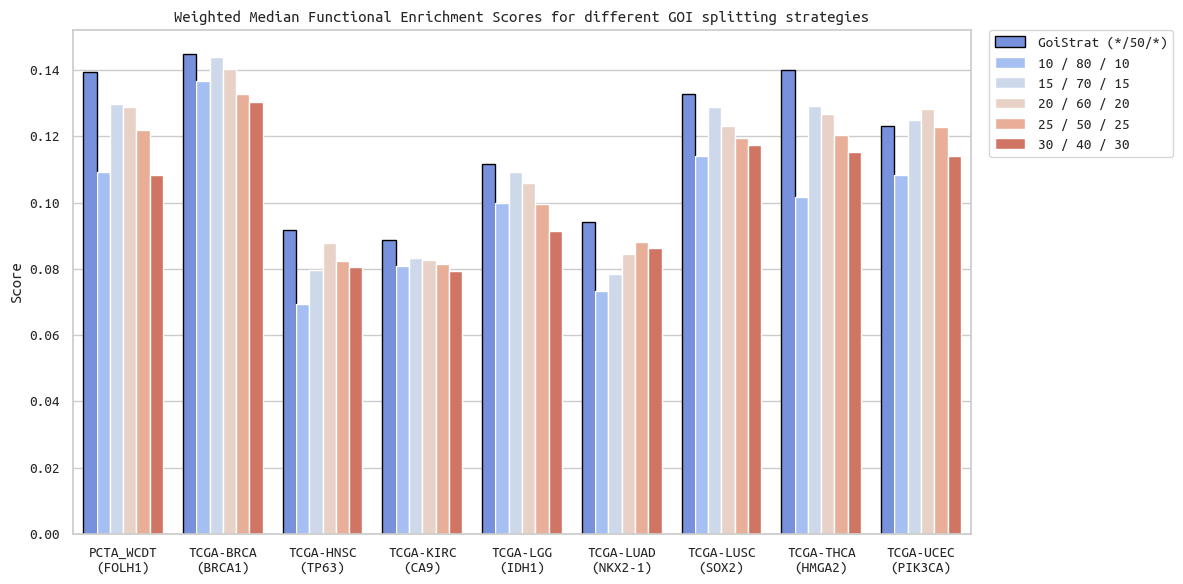

In [21]:
# Melt the DataFrame to long format for seaborn
all_degss_scores_df_weighted_melted = all_degss_scores_df_weighted.reset_index().melt(
    id_vars="index", var_name="Column", value_name="Score"
)
all_degss_scores_df_weighted_melted["index"] = all_degss_scores_df_weighted_melted[
    "index"
].str.replace(" (", "\n(")

all_degss_scores_df_weighted_melted["Column"] = all_degss_scores_df_weighted_melted[
    "Column"
].map(RENAME_DICT)

# Create the barplot
plt.figure(figsize=(12, 6))
barplot = sns.barplot(
    data=all_degss_scores_df_weighted_melted,
    x="index",
    y="Score",
    hue="Column",
    palette=PALETTE_STR,
)

# Customize the plot
plt.xlabel("")
plt.ylabel("Score")
plt.title(
    "Weighted Median Functional Enrichment Scores for different GOI splitting strategies"
)

# Add a black border to the bar corresponding to "GOI_level"
for patch, level in zip(barplot.patches, all_degss_scores_df_weighted_melted["Column"]):
    if level == "GoiStrat (*/50/*)":
        patch.set_edgecolor("black")
        patch.set_linewidth(1)

# Move the legend outside of the figure
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.0)

# Show the plot
plt.tight_layout()

plt.savefig(
    MULTI_DATASET_PATH.joinpath("all_degss_scores_df_weighted_barplot.pdf"),
    bbox_inches="tight",
)
plt.savefig(
    MULTI_DATASET_PATH.joinpath("all_degss_scores_df_weighted_barplot.svg"),
    bbox_inches="tight",
)

plt.show()

- Median functional difference scores have been weighted by the power of the differential analysis test for a fairer comparison.
- We can observe a considerable heterogenity in the ability of each method to successfully split the samples such that the functional differences are maximised. In spite of this, the GoiStrat method demonstrates a higher consistency in its ability to identify functional differences between the high and low groups.
- It ranks first in 8 out of 9 datasets, and a close third in the last one.